# Import everyting here

In [1]:
import torch.utils.data
import matplotlib.pyplot as plt
import torch
import scipy.integrate
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger


from RungeKutta import *

%reload_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
save_location = "./figures/alpha_1,3_"

# Setup Tensorboard

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

Launching TensorBoard...

In [5]:
# train_dataset[0] --> trajectory sets as dict
# train_dataset[0]["traj"] --> first trajectory set 
# train_dataset[0]["traj_shifted"] --> first trajectory set shifted by one (targets)
train_dataset = None # 100x10x2
validation_dataset = None
test_dataset = None

# Create dataset

FIRST VALUE:  1.3264108127040748 1.192727933583312
LAST VALUE:  0.9335363358956899 -0.6655230514892827
FIRST VALUE:  1.9988488731985945 -1.6498730168647127
LAST VALUE:  -0.5174009357953584 -1.0189744083450674


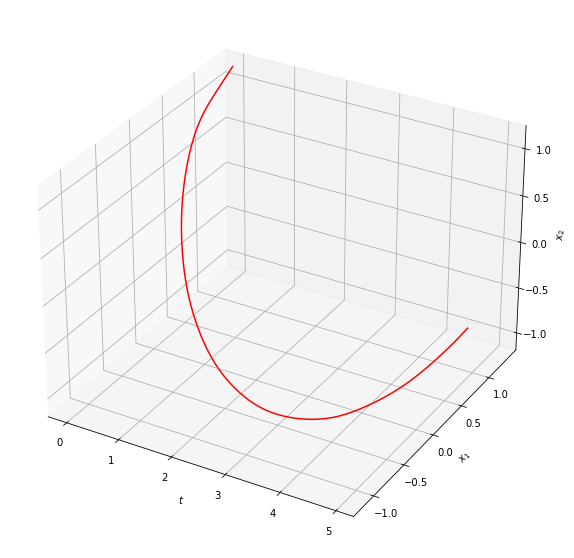

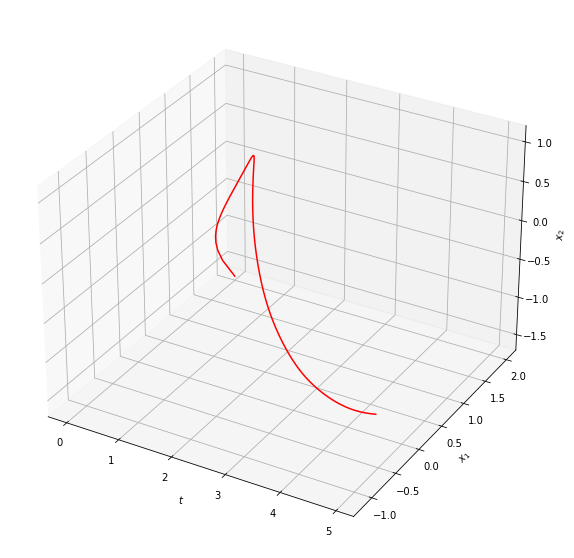

In [6]:
alpha = 1.3
delta_t = 0.05

def get_derivatives(x1, x2, alpha):
    """
    andronov hopf change name
    """
    return alpha * x1 - x2 - x1 * (x1 ** 2 + x2 ** 2), x1 + alpha * x2 - x2 * (x1 ** 2 + x2 ** 2)

start_positions = np.random.uniform(-2, 2, (1000, 2))
sols = []
t_eval = np.arange(0, 5, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[0][0], sols[0][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[0][0][0], sols[0][1][0])
print("LAST VALUE: ", sols[0][0][-1], sols[0][1][-1])

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[-1][0], sols[-1][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[-1][0][0], sols[-1][1][0])
print("LAST VALUE: ", sols[-1][0][-1], sols[-1][1][-1])

# some deep shit here

In [7]:
train_dataset_values = np.array(sols)

train_dataset_targets = np.delete(train_dataset_values, 0, axis=-1)
train_dataset_values = np.delete(train_dataset_values, -1, axis=-1)

print("train_dataset_values shape: ", train_dataset_values.shape)
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset_values = np.moveaxis(train_dataset_values, 1, -1).reshape((train_dataset_values.shape[0] * train_dataset_values.shape[2], 2))
print("train_dataset_values shape: ", train_dataset_values.shape)

train_dataset_targets = np.moveaxis(train_dataset_targets, 1, -1).reshape((train_dataset_targets.shape[0] * train_dataset_targets.shape[2], 2))
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset = np.stack((train_dataset_values, train_dataset_targets))
train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

train_dataset_values shape:  (1000, 2, 99)
train_dataset_targets shape:  (1000, 2, 99)
train_dataset_values shape:  (99000, 2)
train_dataset_targets shape:  (99000, 2)
train_dataset shape:  (99000, 2, 2)


In [ ]:
"""
train_dataset = np.stack((train_dataset_values, train_dataset_targets))
print("train_dataset shape: ", train_dataset.shape)

train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

# As one can see, we could successfully generate the targets!
#print(train_dataset_values[0, :, :10])
#print(train_dataset_targets[0, :, :10])


#values_x = train_dataset_values[:, 0, :]
#values_y = train_dataset_values[:, 1, :]

#A = np.reshape(train_dataset_values, (1000, 9999, 2))
#print(A[0, :10, :])

#train_dataset_targets =

#(1000, 10000, 10000)

#((10000000, 2), (10000000, 2))
"""

# Define hyperparameters

In [8]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [9]:
model = RungeKutta(hparams)

# Validation set

Score of the Model before training: 247.63406131010854


Text(0.5, 0, '$x_2$')

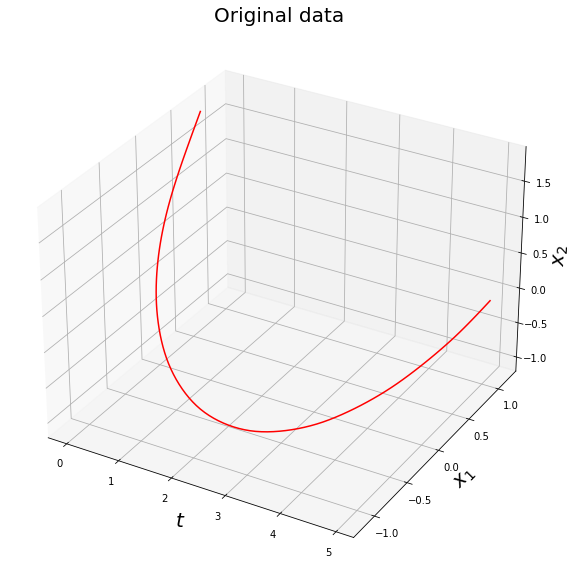

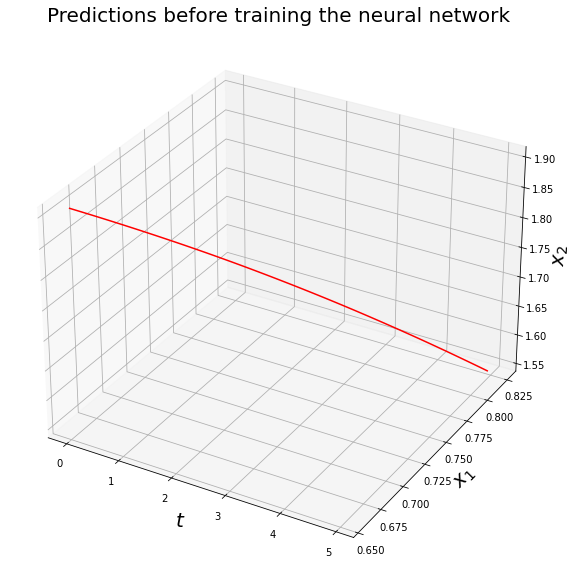

In [10]:
start_positions = np.random.uniform(-2, 2, (200, 2))

sols = []
t_eval = np.arange(0, 5, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)

# plot the first one
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[0][0], sols[0][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_title("Original data", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "original_data.png")
    
validation_dataset_values = np.array(sols)
validation_dataset_targets = np.delete(validation_dataset_values, 0, axis=-1)
validation_dataset_values = np.delete(validation_dataset_values, -1, axis=-1)
validation_dataset_values = np.moveaxis(validation_dataset_values, 1, -1).reshape((validation_dataset_values.shape[0] * validation_dataset_values.shape[2], 2))
validation_dataset_targets = np.moveaxis(validation_dataset_targets, 1, -1).reshape((validation_dataset_targets.shape[0] * validation_dataset_targets.shape[2], 2))
validation_dataset = np.stack((validation_dataset_values, validation_dataset_targets))
validation_dataset = np.moveaxis(validation_dataset, 0, 1)

def evaluate_model(model, dataset):
    """
    TODO
    """
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=hparams["batch_size"], shuffle=False)
    loss = 0
    for batch in dataloader:
        pos = batch[:, 0]
        pos_target = batch[:, 1]
        
        pred = model.forward(pos.float()).to(device)
        
        loss += criterion(pred, pos_target.float()).item()
    return 1.0 / (2 * (loss / len(dataloader)))


def recreate_trajectory(model, start_position, t_start, t_end, delta_t):
    """
    TODO
    """
    trajectory = [start_position]
    last_traj = torch.tensor(start_position)
    last_traj = last_traj.to(device)
    t0 = t_start

    while t0 < t_end - delta_t:
        last_traj = model.forward(last_traj.float())
        trajectory.append(last_traj.detach().numpy())
        t0 += delta_t
        
    return trajectory

print("Score of the Model before training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)
recreation = np.array(recreation)

fig0 = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[:, 0], recreation[:, 1], color="r")

ax0.set_title("Predictions before training the neural network", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig0.savefig(save_location + "pred_b_train.png");

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)
validation__dataloader = torch.utils.data.DataLoader(validation_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)

In [13]:
trainer = pl.Trainer(
    max_epochs=5,
    log_every_n_steps=5,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Score of the Model after training: 52604.50977501981


Text(0.5, 0, '$x_2$')

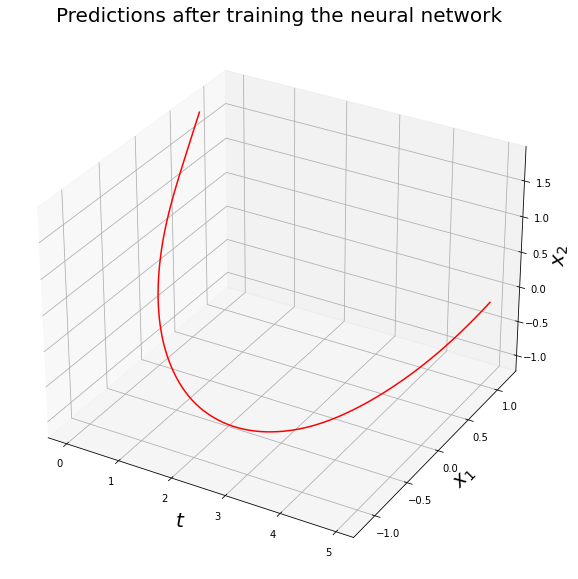

In [14]:
print("Score of the Model after training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)
recreation = np.array(recreation)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[:, 0], recreation[:, 1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_title("Predictions after training the neural network", fontsize=20)
ax0.set_xlabel(r"$t$", fontsize=20)
ax0.set_ylabel(r"$x_1$", fontsize=20)
ax0.set_zlabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "pred_a_train.png");

Text(0, 0.5, '$x_2$')

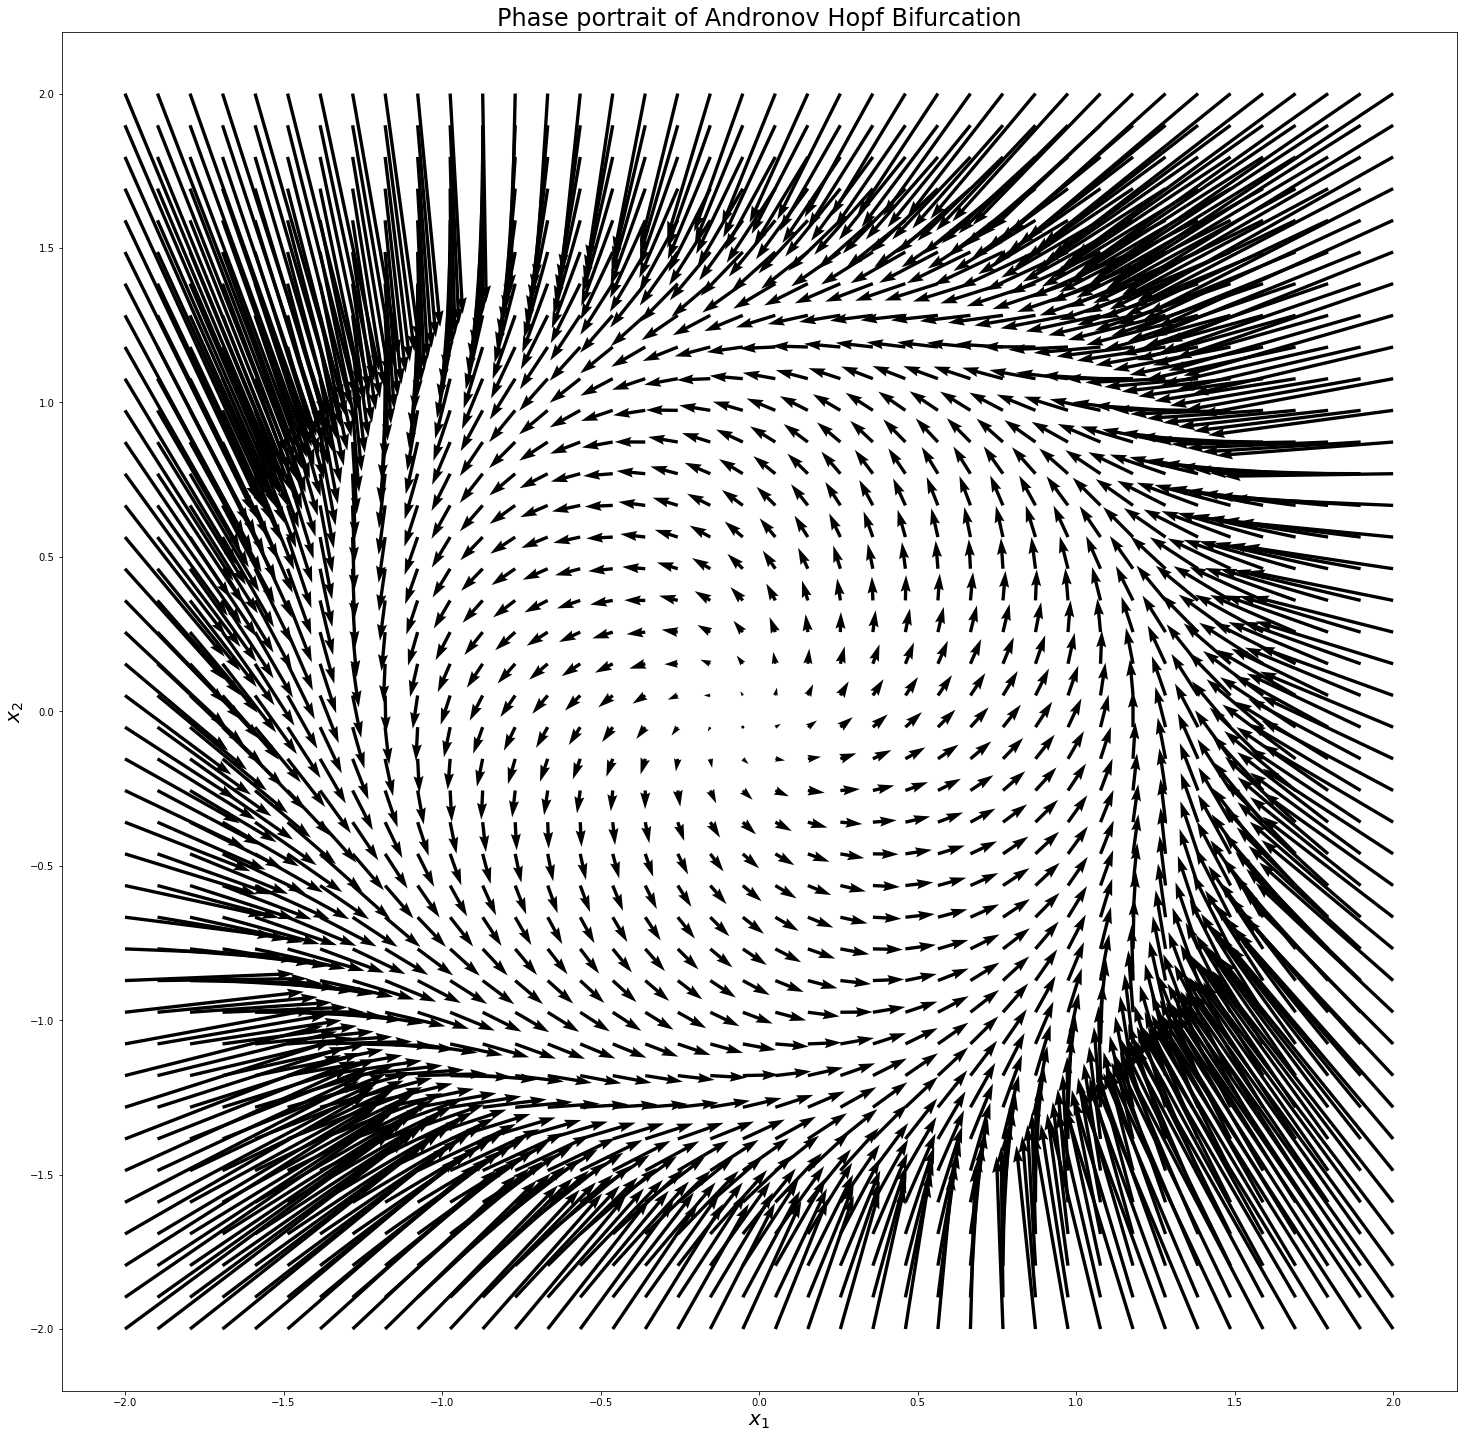

In [15]:
positions = np.empty((40, 40, 2))
next_positions = np.empty((40, 40, 2))
for idx1, i in enumerate(np.linspace(-2, 2, 40)):
    for idx2, j in enumerate(np.linspace(-2, 2, 40)):
        positions[idx1][idx2] = np.array((i, j))
        position = torch.tensor((i, j))
        next_positions[idx1][idx2] = (model(position.float())).detach().numpy()
derivatives = (next_positions - positions) / delta_t
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot()
ax.quiver(positions[:, :, 0], positions[:, :, 1], derivatives[:, :, 0], derivatives[:, :, 1], units="xy", scale=10)
ax.set_title(r"Phase portrait of Andronov Hopf Bifurcation", fontsize=24)
ax.set_xlabel(r"$x_1$", fontsize=20)
ax.set_ylabel(r"$x_2$", fontsize=20)
#fig.savefig(save_location + "phase_portrait.png");